# Bridge weigh-in-motion

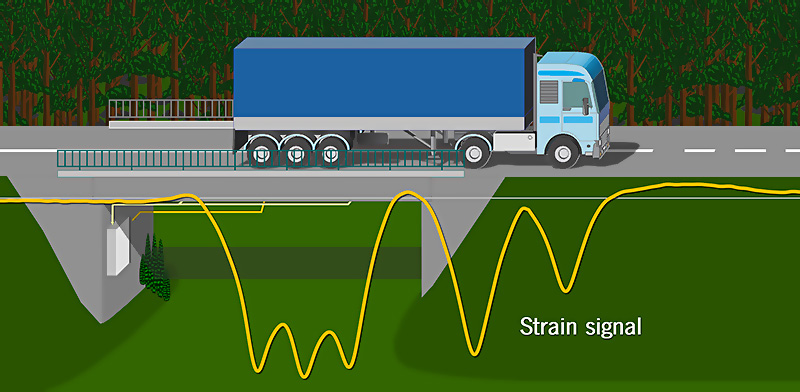

In [2]:
import numpy as np
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt

#import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import torch.utils.data as utils

from bokeh.plotting import figure
from bokeh.layouts import gridplot, row, column
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

## Modèle BWIM

Considerons le passage d'un véhicule sur un pont. L'effet induit par le déplacement du vehicule en un point donné de la structure peut s'exprimer comme suit :

$$ y(t) = \sum_{a=1}^{A} w_a h(t - \tau_a) $$

où 
 - $A$ - nombre d'essieux du vehicule,
 - $w_a$ - poid du vehicule sur l'essieu $a$,
 - $\tau_a$ - instant de passage de l'essieu $a$,
 - $h(t)$ - fonction qui decrit l'effet induit par un chargement unitaire qui se deplace sur le pont à la meme vitesse du vehicule consideré.


### Exemple

La figure suivante illustre les signaux $y(t)$ et $h(t-\tau_a)$ pour un vehicule à 3 essieux. 

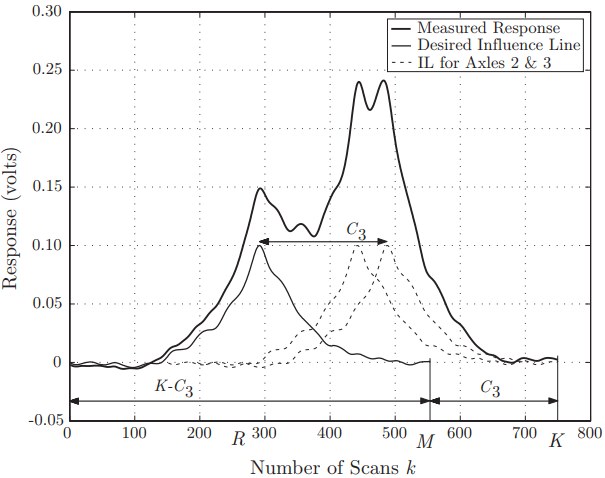

### Ligne d'influence

Dans le modèle ci-dessus, la fonction $h(t)$ depend de la vitesse $v$ du vehicule: 

$$ h(t) = g(vt), $$

où $g(x)$ est la **ligne d'influence** de la structure. Nous pouvons alors deduire que

$$ h(t-\tau_a) = g(vt - v\tau_a) = g\big(v(t - t_0) - d_a\big), $$

où $d_a$ est la distance entre l'essieu $a$ et l'essieu $1$ (donc $d_1 = 0$).

Les figures ci-dessous montrent la ligne d'influence $g(x)$ d'un pont. On remarque que l'axe des abscisses est indiquée en metres.

| Exemple 1 | Exemple 2 |
|-----------|-----------|
| 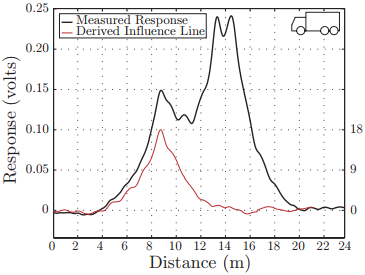 | 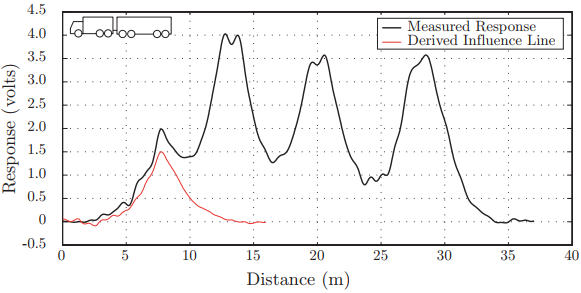 |

### Modèle multi-vehicule

Lors du passage de **plusieurs vehicules**, l'effet induit sur la structure est la somme des effets produits par chaque vehicule:

$$ y(t) = \sum_{n=1}^N \sum_{a=1}^{A^{(n)}} w_a^{(n)} h\big(t - \tau_a^{(n)}\big) $$

où $N$ est le nombre de vehicules, $A_n$ est le nombre d'essieux du vehicule $n$, et $\tau_a^{(n)}$ est l'instant de passage de l'essieu $a$ du vehicule $n$. 

Les figures ci-dessous illustrent les lignes d'influence enregistrées par un capteur installé sous la voie 1 lorsque un vehicule traverse le pont sur la voie 1 ou sur la voie 2. A gauche, les lignes d'influence estimées en phase de calibration. A droite, les lignes d'influence enregistrées en presence d'un vehicule à 2 essieux qui voyage sur la voie 2 à 12 m/s, suivi après 0.2 secondes par un vehicule à 3 essieux qui voyage sur la voie 1 à 10 m/s.

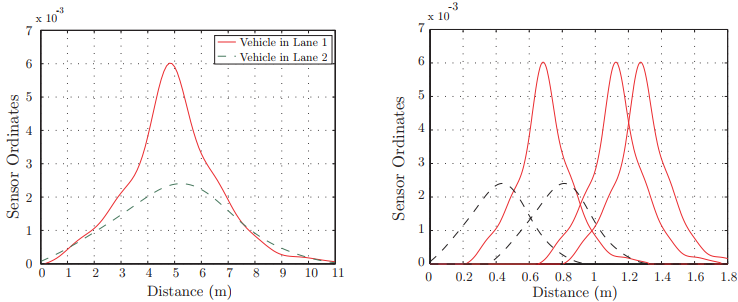

### Discrétisation

Soit $f_s = 1/T_s$ la frequence d'echantillonage du systeme, et $t_0$ l'instant d'entrée du vehicule sur le pont.

- Le signal observé est representé par un vecteur de taille $K$:

$$ {\bf y} = \big[y(t_0 + kT_s)\big]_{k\in\{0,\dots,K-1\}}. $$

- La ligne d'influence est representé par un vecteur de taille $M\le K$:

$$ {\bf h} = \big[h(mT_s)\big]_{m\in\{0,\dots,M-1\}}. $$

- L'instant $\tau_a$ est representé par un vecteur de taille $K$ qui prend la valeur $1$ en position $c_a$ (echantillon correspondant au temps $\tau_a$) et $0$ autrement:

$$
\boldsymbol{\delta}_a = \big[\delta_{k,c_a}\big]_{k\in\{0,\dots,K-1\}} = \big[0\;\dots\;0\;\underbrace{1}_{c_a}\;0\;\dots\;0\big]^\top.
$$

Le modèle BWIM peut alors se traduire par la rélation suivante:

$$ {\bf y}_s = \sum_{a=1}^A w_a \, \boldsymbol{\delta}_{a,s} * {\bf h}_s, $$

où l'indice $s$ distingue les differents signaux observés. L'objectif ici est de retrouver les poids ${\bf w}=[w_1,\dots,w_a]^\top$ et les lignes d'influence ${\bf h}_s$ à partir des signaux observés ${\bf y}_s$ et des instants de passage $\tau_{1,s},\dots,\tau_{A,s}$. 